# 프로젝트: ResNet Ablation Study

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 애블레이션 연구(ablation study)
딥러닝 논문은 여러 가지 방법들을 결합해서 어떤 문제를 해결하는 방법을 제시합니다. 이때 제안한 방법들의 유효함을 증명하기 위해서 보통 딥러닝 논문에서는 해당 방법을 "제거"한 모델로 수행한 실험과, 해당 방법을 추가한 모델로 수행한 실험의 결과를 비교합니다. 애블레이션 연구란 이처럼 "아이디어를 제거해 봄으로써" 제안한 방법이 어떻게 성능이나 문제에 해결에 효과를 주는지 확인하는 실험입니다.

## Resnet 기본 블럭

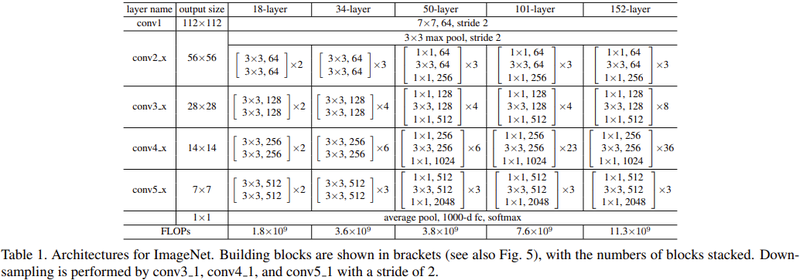

* ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. 
* ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, 
* ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

In [3]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [4]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [5]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [6]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][

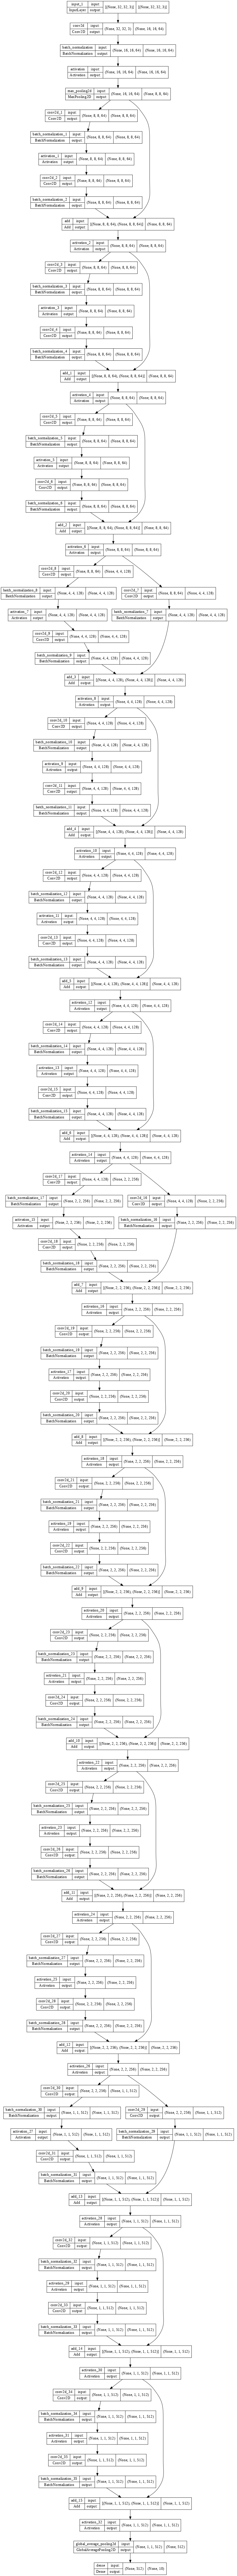

In [7]:
tf.keras.utils.plot_model(resnet_34, show_shapes=True, dpi=64)

In [8]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 16, 16, 64)  256         ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_33 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_36[

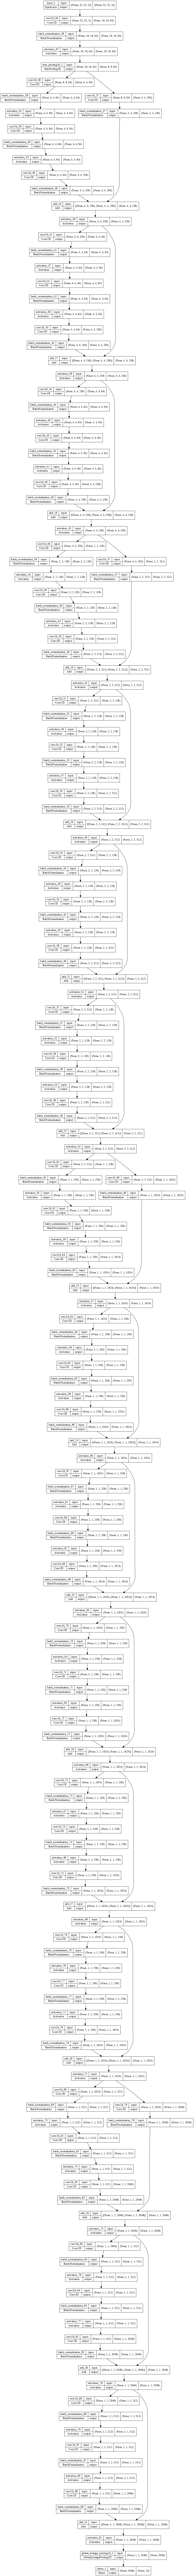

In [9]:
tf.keras.utils.plot_model(resnet_50, show_shapes=True, dpi=64)

## 일반 네트워크(plain network)

In [10]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [11]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

In [12]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        369

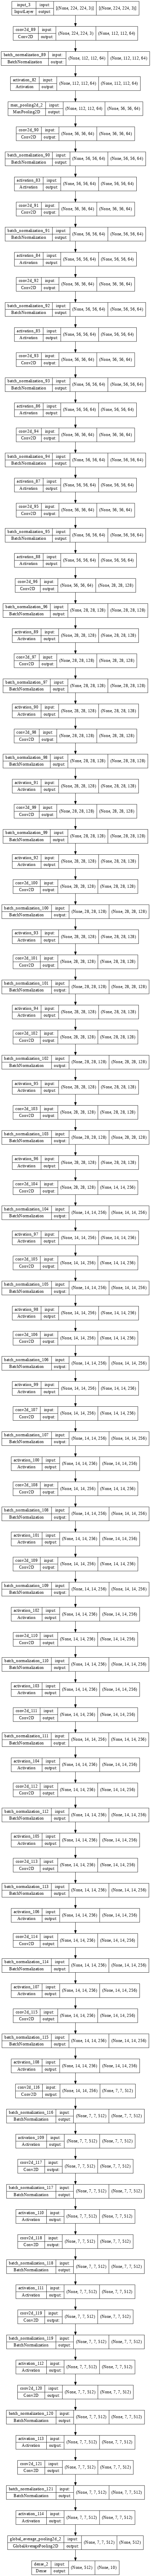

In [13]:
tf.keras.utils.plot_model(plain_34, show_shapes=True, dpi=64)

In [14]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        416

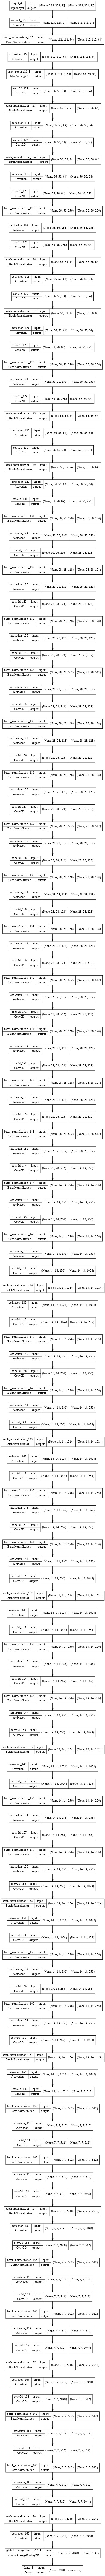

In [15]:
tf.keras.utils.plot_model(plain_50, show_shapes=True, dpi=64)

## 데이터셋 준비

In [16]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZWB010/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [17]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [18]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [19]:
print(f'Train 이미지 개수 : {len(ds_train)}')
print(f'Test 이미지 개수 : {len(ds_test)}')

Train 이미지 개수 : 18610
Test 이미지 개수 : 4652


* Data Normalization 은 데이터의 범위를 사용자가 원하는 범위로 제한하는 것입니다. Data Normalization을 하는 이유는 머신러닝에서 scale이 큰 feature의 영향이 비대해지는 것을 방지하고, 딥러닝에서 Local optimum에 빠질 위험을 줄이는(학습 속도 향상) 거예요.

In [20]:
# 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [21]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

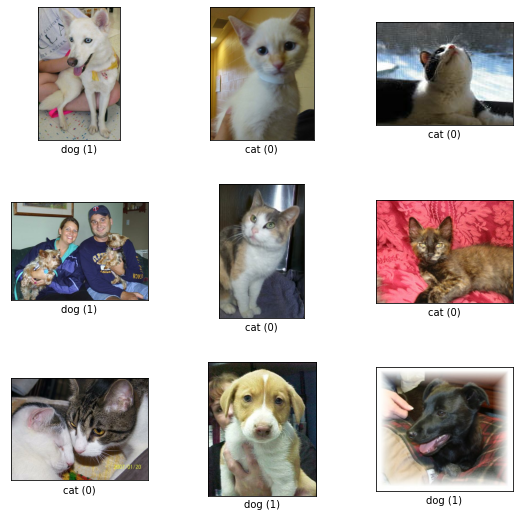

In [22]:
fig = tfds.show_examples(ds_train, ds_info)

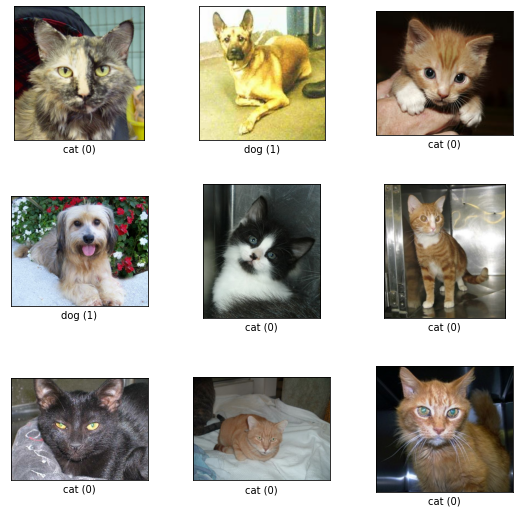

In [23]:
fig = tfds.show_examples(ds_test, ds_info)

## 모델 훈련

In [24]:
BATCH_SIZE = 64
EPOCH = 40

In [25]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [26]:
model_resnet_34 = build_resnet(input_shape=(224, 224, 3),                                
                               num_classes=1, 
                               is_50=False, 
                               activation='sigmoid', 
                               name='ResNet_34')

In [27]:
model_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = model_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/40
290/290 [==============================] - 99s 243ms/step - loss: 2.2200 - accuracy: 0.6555 - val_loss: 1.9199 - val_accuracy: 0.6795
Epoch 2/40
290/290 [==============================] - 67s 230ms/step - loss: 1.5800 - accuracy: 0.7596 - val_loss: 1.4477 - val_accuracy: 0.6623
Epoch 3/40
290/290 [==============================] - 66s 228ms/step - loss: 1.1267 - accuracy: 0.8171 - val_loss: 0.9982 - val_accuracy: 0.8191
Epoch 4/40
290/290 [==============================] - 67s 230ms/step - loss: 0.8313 - accuracy: 0.8628 - val_loss: 0.7590 - val_accuracy: 0.8684
Epoch 5/40
290/290 [==============================] - 66s 229ms/step - loss: 0.6479 - accuracy: 0.8888 - val_loss: 0.7981 - val_accuracy: 0.7629
Epoch 6/40
290/290 [==============================] - 66s 229ms/step - loss: 0.5327 - accuracy: 0.9069 - val_loss: 0.9241 - val_accuracy: 0.7361
Epoch 7/40
290/290 [==============================] - 66s 229ms/step - loss: 0.4550 - accuracy: 0.9197 - val_loss: 1.1204 - val_ac

In [28]:
model_resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

In [29]:
model_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = model_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
290/290 [==============================] - 71s 179ms/step - loss: 5.2212 - accuracy: 0.6507 - val_loss: 4.4083 - val_accuracy: 0.6571
Epoch 2/40
290/290 [==============================] - 51s 176ms/step - loss: 3.4053 - accuracy: 0.7315 - val_loss: 3.3390 - val_accuracy: 0.5822
Epoch 3/40
290/290 [==============================] - 51s 176ms/step - loss: 2.3350 - accuracy: 0.7767 - val_loss: 2.2608 - val_accuracy: 0.6289
Epoch 4/40
290/290 [==============================] - 51s 176ms/step - loss: 1.7258 - accuracy: 0.8183 - val_loss: 1.8005 - val_accuracy: 0.7446
Epoch 5/40
290/290 [==============================] - 51s 176ms/step - loss: 1.3482 - accuracy: 0.8455 - val_loss: 1.5101 - val_accuracy: 0.7233
Epoch 6/40
290/290 [==============================] - 51s 177ms/step - loss: 1.0832 - accuracy: 0.8776 - val_loss: 1.1131 - val_accuracy: 0.8314
Epoch 7/40
290/290 [==============================] - 51s 176ms/step - loss: 0.9141 - accuracy: 0.9005 - val_loss: 1.1806 - val_ac

In [30]:
model_plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

In [31]:
model_plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

history_plain_34 = model_plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
290/290 [==============================] - 80s 224ms/step - loss: 1.8093 - accuracy: 0.5596 - val_loss: 1.4842 - val_accuracy: 0.5501
Epoch 2/40
290/290 [==============================] - 64s 221ms/step - loss: 1.2268 - accuracy: 0.6172 - val_loss: 1.1555 - val_accuracy: 0.4855
Epoch 3/40
290/290 [==============================] - 64s 221ms/step - loss: 1.0148 - accuracy: 0.6332 - val_loss: 1.9270 - val_accuracy: 0.5117
Epoch 4/40
290/290 [==============================] - 64s 221ms/step - loss: 0.8639 - accuracy: 0.6874 - val_loss: 0.8787 - val_accuracy: 0.6491
Epoch 5/40
290/290 [==============================] - 64s 222ms/step - loss: 0.7667 - accuracy: 0.7183 - val_loss: 0.8632 - val_accuracy: 0.5751
Epoch 6/40
290/290 [==============================] - 65s 223ms/step - loss: 0.7412 - accuracy: 0.7267 - val_loss: 0.8096 - val_accuracy: 0.5131
Epoch 7/40
290/290 [==============================] - 65s 223ms/step - loss: 0.6612 - accuracy: 0.7617 - val_loss: 0.8321 - val_ac

In [32]:
model_plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

In [33]:
model_plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

history_plain_50 = model_plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
290/290 [==============================] - 110s 315ms/step - loss: 4.1020 - accuracy: 0.5678 - val_loss: 3.2767 - val_accuracy: 0.4912
Epoch 2/40
290/290 [==============================] - 90s 311ms/step - loss: 2.6615 - accuracy: 0.6093 - val_loss: 2.4011 - val_accuracy: 0.5026
Epoch 3/40
290/290 [==============================] - 90s 310ms/step - loss: 2.1263 - accuracy: 0.5928 - val_loss: 5.6015 - val_accuracy: 0.5056
Epoch 4/40
290/290 [==============================] - 90s 312ms/step - loss: 1.8453 - accuracy: 0.5979 - val_loss: 1.7509 - val_accuracy: 0.4884
Epoch 5/40
290/290 [==============================] - 90s 311ms/step - loss: 1.6037 - accuracy: 0.6138 - val_loss: 1.5819 - val_accuracy: 0.5100
Epoch 6/40
290/290 [==============================] - 90s 311ms/step - loss: 1.4490 - accuracy: 0.6311 - val_loss: 2.3849 - val_accuracy: 0.6254
Epoch 7/40
290/290 [==============================] - 90s 311ms/step - loss: 1.3103 - accuracy: 0.6850 - val_loss: 1.5793 - val_a

## ResNet-50 vs Plain-50, ResNet-34 vs Plain-34 비교

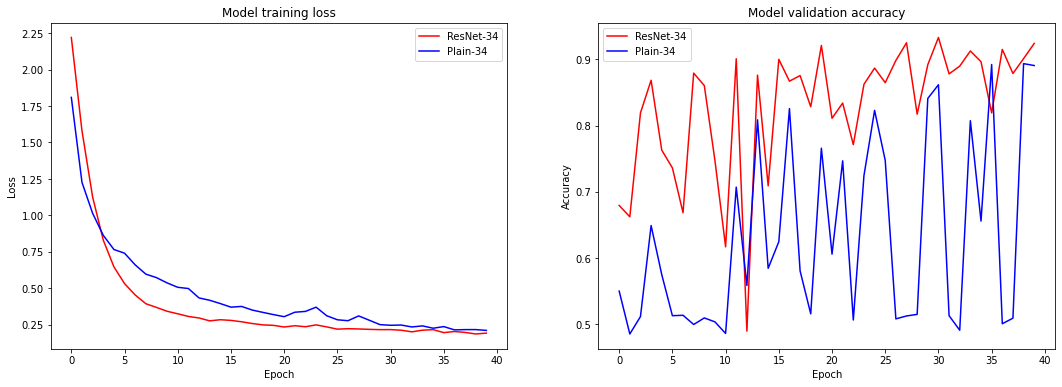

In [34]:
# ResNet-34 vs Plain-34
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

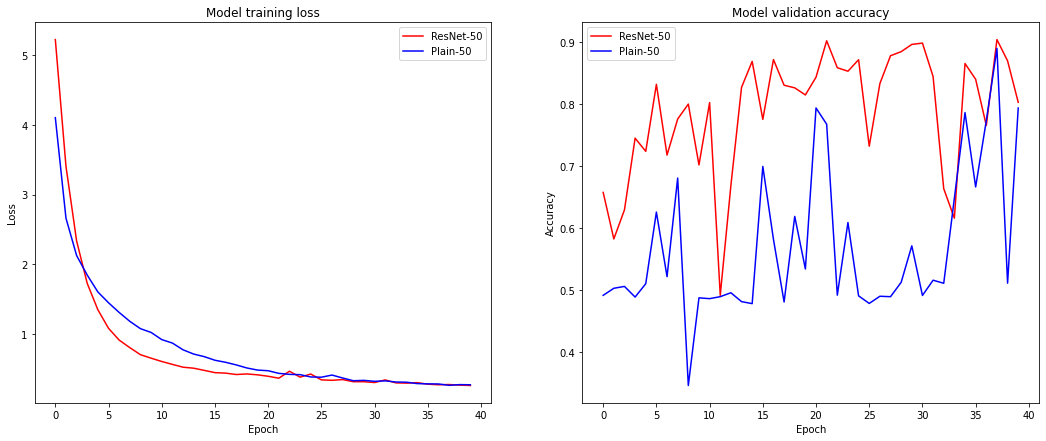

In [35]:
# ResNet-50 vs Plain-50
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

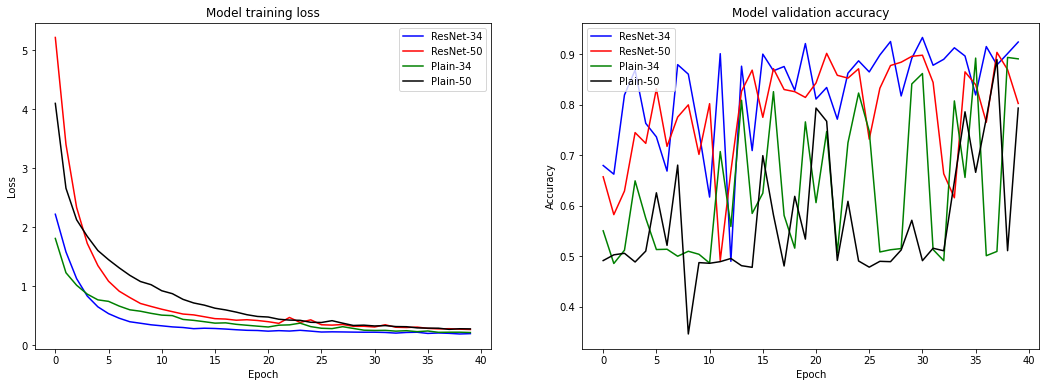

In [36]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'b')
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'g')
plt.plot(history_plain_50.history['loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'g')
plt.plot(history_plain_50.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

In [37]:
import pandas as pd

accuracy_data = {'Resnet-34': history_resnet_34.history['val_accuracy'],
                 'Resnet-50': history_resnet_50.history['val_accuracy'], 
                 'Plain-34': history_plain_34.history['val_accuracy'], 
                 'Plain-50': history_plain_50.history['val_accuracy']}
accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df.tail()

Resnet-34  Resnet-50  Plain-34  Plain-50
35   0.819093   0.839410  0.892110  0.665937
36   0.914931   0.765039  0.500872  0.772767
37   0.878596   0.903444  0.509332  0.889229
38   0.901042   0.869141  0.893418  0.510851
39   0.923923   0.802300  0.890584  0.793156

In [38]:
accuracy_df.describe()

Resnet-34  Resnet-50   Plain-34   Plain-50
count  40.000000  40.000000  40.000000  40.000000
mean    0.829401   0.788609   0.632877   0.569360
std     0.098674   0.099029   0.142178   0.120041
min     0.489756   0.491282   0.485460   0.345920
25%     0.801057   0.729535   0.511208   0.489592
50%     0.867661   0.826017   0.577866   0.510765
75%     0.896743   0.865717   0.751990   0.631020
max     0.932943   0.903444   0.893418   0.889229

In [39]:
loss_data = {'Resnet-34': history_resnet_34.history['val_loss'],
             'Resnet-50': history_resnet_50.history['val_loss'],
             'Plain-34': history_plain_34.history['val_loss'], 
             'Plain-50': history_plain_50.history['val_loss']}
loss_df = pd.DataFrame(loss_data)
loss_df.tail()

Resnet-34  Resnet-50  Plain-34  Plain-50
35   0.818733   1.279202  0.425839  1.041435
36   0.510146   0.883112  0.762273  0.826956
37   0.417134   0.579412  0.694662  0.618394
38   0.484653   0.561169  0.481013  3.453234
39   0.339189   1.307521  0.404678  0.788053

In [40]:
loss_df.describe()

Resnet-34  Resnet-50   Plain-34    Plain-50
count  40.000000  40.000000  40.000000   40.000000
mean    0.702883   1.291614   1.460276    5.456763
std     0.529313   1.107363   3.137627   18.951943
min     0.326805   0.492938   0.404678    0.618394
25%     0.416523   0.689940   0.680540    0.965866
50%     0.500217   0.958422   0.783817    1.373389
75%     0.768731   1.282003   0.898048    2.388948
max     2.929145   5.647108  20.327229  120.211792

# 회고
* Resnet_34와 Plain_34를 비교했을때, Loss도 Resnet_34가 Plain_34보다 더 낮게 수렴하는 양상을 보였고, Accuracy도 epoch가 많아질수록 Plain_34보다 Resnet_34가 더 높아지는 것을 확인했다. skip connection이 있는 Resnet_34모델이 성능이 더 높은 것을 알 수 있었다.
* Resnet_50과 Plain_50을 비교했을때 역시, Loss도 Resnet_50이 Plain_50보다 미미한 차이지만 더 낮게 수렴하는 모습을 보였고, Accuracy도 Resnet_50이 Plain_50보다 높게 나오는 것을 확인했다. skip connection이 있는 Resnet_50모델이 성능이 더 높은 것을 알 수 있었다.
* epoch를 더 돌릴수록 skip connection 유무에 따른 성능차이가 더 뚜렸해질 것으로 예상된다.
